In [1]:
# Basic Libraries
import pandas as pd

/var/folders/lr/2ljfkpxj1851pmkswdvzvnhm0000gn/T/ipykernel_16960/1674333908.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# focus on a momentum-based strategy, leveraging on rolling walk-forward analysis to adapt and optimize the model over time
# Load USDX data
usdx_data = pd.read_csv('$USDX.csv', parse_dates=['Date'], index_col='Date')
# parse_dates =["date"], converts the "date" column to date-time format

# sanity check
usdx_data.head()

,Open,High,Low,Close
Date,,,,
1971-01-04,120.53,120.53,120.53,120.53
1971-01-05,120.52,120.52,120.52,120.52
1971-01-06,120.49,120.49,120.49,120.49
1971-01-07,120.55,120.55,120.55,120.55
1971-01-08,120.53,120.53,120.53,120.53


In [3]:
# Feature engineering: Calculate moving averages and rate of change
usdx_data['SMA_10'] = usdx_data['Close'].rolling(window=10).mean() #simple 10 - 
usdx_data['SMA_30'] = usdx_data['Close'].rolling(window=30).mean()
usdx_data['ROC'] = usdx_data['Close'].pct_change(periods=10)

# Drop any NaN values that result from rolling calculations
usdx_data = usdx_data.dropna()

# Display the processed data
usdx_data.head()

,Open,High,Low,Close,SMA_10,SMA_30,ROC
Date,,,,,,,
1971-02-16,120.22,120.22,120.22,120.22,120.258,120.353333,-0.000166
1971-02-17,120.21,120.21,120.21,120.21,120.253,120.342667,-0.000416
1971-02-18,120.21,120.21,120.21,120.21,120.246,120.332333,-0.000582
1971-02-19,120.18,120.18,120.18,120.18,120.240,120.322000,-0.000499
1971-02-22,120.14,120.14,120.14,120.14,120.230,120.308333,-0.000832


In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Define the rolling window and step size
window_size = 100  # Number of days in each training window
step_size = 30     # Number of days to move forward each iteration

# Initialize lists to store results
predictions = []
actuals = []

# Rolling walk-forward analysis
for start in range(0, len(usdx_data) - window_size, step_size):
    end = start + window_size
    train = usdx_data.iloc[start:end]
    test = usdx_data.iloc[end:end + step_size]
    
    # Define features and target
    X_train = train[['SMA_10', 'SMA_30', 'ROC']]

    # shift() method that shifts the values of a DataFrame along a specified axis 

    # shift the index axis by 1 period in the negative direction
    y_train = (train['Close'].shift(-1) > train['Close']).astype(int)  # Binary target: 1 if price will go up, 0 if down
    
    X_test = test[['SMA_10', 'SMA_30', 'ROC']]
    
    y_test = (test['Close'].shift(-1) > test['Close']).astype(int)
    
    # Train logistic regression model
    model = LogisticRegression()
    model.fit(X_train, y_train)
    
    # Make predictions
    preds = model.predict(X_test)
    
    # Store predictions and actual values
    predictions.extend(preds)
    actuals.extend(y_test)

# Calculate accuracy of the model
accuracy = accuracy_score(actuals, predictions)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.50


/var/folders/lr/2ljfkpxj1851pmkswdvzvnhm0000gn/T/ipykernel_16960/3049800369.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  usdx_data['Prediction'].iloc[window_size::step_size] = predictions[:len(usdx_data) - window_size:step_size]


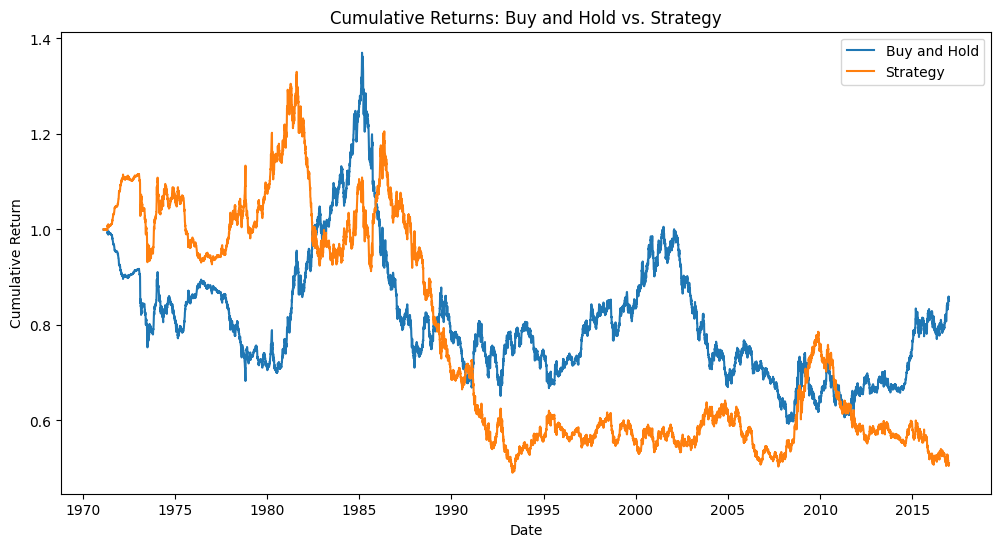

In [9]:
import numpy as np

# Add predictions to the original dataset for further analysis
usdx_data['Prediction'] = np.nan

# .iloc for index slicing
usdx_data['Prediction'].iloc[window_size::step_size] = predictions[:len(usdx_data) - window_size:step_size]

# Forward fill predictions to apply the same position until the next prediction
usdx_data['Prediction'] = usdx_data['Prediction'].ffill().dropna()

# Define positions based on predictions
usdx_data['Position'] = usdx_data['Prediction'].apply(lambda x: 1 if x == 1 else -1)

# Calculate returns
usdx_data['Return'] = usdx_data['Close'].pct_change() # fractional change between current and prior element
usdx_data['Strategy_Return'] = usdx_data['Position'].shift(1) * usdx_data['Return']

# Calculate cumulative returns
usdx_data['Cumulative_Return'] = (1 + usdx_data['Return']).cumprod()
usdx_data['Strategy_Cumulative_Return'] = (1 + usdx_data['Strategy_Return']).cumprod()

# Plot cumulative returns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(usdx_data['Cumulative_Return'], label='Buy and Hold')
plt.plot(usdx_data['Strategy_Cumulative_Return'], label='Strategy')
plt.legend()
plt.title('Cumulative Returns: Buy and Hold vs. Strategy')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.show()